## TensorFlow Benchmark Inference W/ Training and W/ ONNX (Exported from Pytorch) Using LeNet-5 Model On MNIST Dataset


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
import time


class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output


data_train = MNIST('./data',
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor()]))
data_test = MNIST('./data',
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor()]))
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=1024, num_workers=8)

net = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=2e-3)

cur_batch_win = None
cur_batch_win_opts = {
    'title': 'Epoch Loss Trace',
    'xlabel': 'Batch Number',
    'ylabel': 'Loss',
    'width': 1200,
    'height': 600,
}


def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    for i, (images, labels) in enumerate(data_train_loader):
        optimizer.zero_grad()

        output = net(images)

        loss = criterion(output, labels)

        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)

        if i % 1000 == 0:
            print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))


        loss.backward()
        optimizer.step()


def test():
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    for i, (images, labels) in enumerate(data_test_loader):
        output = net(images)
        avg_loss += criterion(output, labels).sum()
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()

    avg_loss /= len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct) / len(data_test)))

In [3]:
for e in range(1, 6):
    train(e)

Train - Epoch 1, Batch: 0, Loss: 2.311580
Train - Epoch 2, Batch: 0, Loss: 0.128709
Train - Epoch 3, Batch: 0, Loss: 0.081194
Train - Epoch 4, Batch: 0, Loss: 0.047460
Train - Epoch 5, Batch: 0, Loss: 0.038182


In [4]:
test()

Test Avg. Loss: 0.000046, Accuracy: 0.985500


In [5]:
from torch.autograd import Variable

torch.save(net.state_dict(), 'output/mnist.pth')

# Load the trained model from file
trained_model = LeNet5()
trained_model.load_state_dict(torch.load('output/mnist.pth'))

# Export the trained model to ONNX
dummy_input = Variable(torch.randn(1, 1, 32, 32)) # one black and white 28 x 28 picture will be the input to the model
torch.onnx.export(trained_model, dummy_input, "output/mnist_LeNet.onnx")

In [6]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX file
onnx_model = onnx.load('output/mnist_LeNet.onnx')

# Import the ONNX model to Tensorflow
tf_rep = prepare(onnx_model)

In [7]:
 def performance_tensorflow_model(model, inputs, warmup_iters=3, main_iters=10):
    '''
     Run the model several times, and measure the execution time.
     Print the execution time per iteration (millisecond) and the number of iterations per second.
    '''

    for _i in range(warmup_iters):
        output = tf_rep.run(inputs)
    execution_time = []
    total_time = 0.0
    for _i in range(main_iters):
        ts = time.time()
        output = tf_rep.run(inputs)
        te = time.time()
        execution_time.append((te - ts)* 1000)
        total_time += (te - ts)
    print("The Tensorflow model execution time per iter is {} milliseconds, "
          "{} iters per second.".format(total_time / main_iters * 1000,
                                        main_iters / total_time))
    return execution_time

In [8]:
import numpy as np
it = iter(data_test_loader)
first = next(it)
tensorflow_inputs = first[0][0].numpy().reshape(1,1,32,32)
output = tf_rep.run(tensorflow_inputs)
print(np.argmax(output), first[1][0].numpy())

7 7


In [9]:
import time
execution_time = performance_tensorflow_model(onnx_model, tensorflow_inputs, warmup_iters=3,main_iters=100)

The Tensorflow model execution time per iter is 21.22497320175171 milliseconds, 47.1143115468089 iters per second.


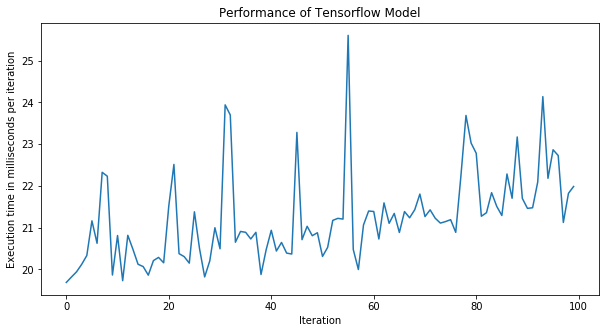

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(execution_time)
plt.ylabel('Execution time in milliseconds per iteration')
plt.xlabel('Iteration')
plt.title('Performance of Tensorflow Model')
plt.show()